# Question 1

$$ \begin{align}
\int^b&_a N(1+\alpha x+\beta x^2) dx=1\\
N&=\frac{1}{(b-a)+\frac{(b^2-a^2)\alpha}{2}+\frac{(b^3-a^3)\beta}{3}}

\end{align}$$

$$ \begin{align}

E(X)&=\int^b_a N(x+\alpha x^2+\beta x^3)dx\\
&=N(\frac{(b^2-a^2)}{2})+\alpha N\frac{b^3-a^3}{3}+\beta \frac{b^4-a^4}{4}N\\
&=N d_2+\alpha N d_3+\beta N d_4\\
E(X^2)&=\int^b_a N(x^2+\alpha x^3+\beta x^4)dx\\
&=N(\frac{b^3-a^3}{3})+\alpha N\frac{b^4-a^4}{4}+\beta \frac{b^5-a^5}{5}N\\
&=N d_3+\alpha Nd_4+\beta Nd_5
\end{align}$$

$$ \begin{align}
\alpha &= \frac{d_5 E(X)-d_4 E(X^2)-Nd_2d_5+Nd_3d_4}{Nd_3d_5-Nd_4^2}\\
\beta &= \frac{d_4 E(X)-d_3 E(X^2)+Nd_3d_3-Nd_2d_4}{Nd_4^2-Nd_5d_3}
\end{align}$$

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

In [189]:
def pdf(x, alpha, beta, a, b):
    """Calculate the probability density function value."""
    # Calculate normalization parameter N
    def d_k(k):
        return (b**k - a**k) / k
    
    N = 1 / (d_k(1) + alpha * d_k(2) + beta * d_k(3))
    
    return N * (1 + alpha*x + beta*x**2)

In [190]:
def find_pdf_maximum(alpha, beta, a, b):
    """Find the maximum value of the PDF using scipy.optimize."""
    # Define negative PDF for minimization (since we want maximum)
    def neg_pdf(x):
        return -pdf(x, alpha, beta, a, b)
    
    # Use scipy's minimize_scalar with bounds
    result = minimize_scalar(neg_pdf, bounds=(a, b), method='bounded')
    
    return -result.fun  # Return positive maximum value

In [191]:
def generate_samples(n_samples, alpha, beta, a, b):
    """Generate samples using accept-reject method."""
    samples = []
    accepted_y = []
    M = find_pdf_maximum(alpha, beta, a, b)
    count = 0
    while len(samples) < n_samples:
        # Generate uniform random points
        x = np.random.uniform(a, b)
        y = np.random.uniform(0, M)
        
        # Accept or reject
        if y <= pdf(x, alpha, beta, a, b):
            samples.append(x)
            accepted_y.append(y)
        count += 1
    acceptance_rate = n_samples / count
    return np.array(samples),np.array(accepted_y), count

In [192]:
# Parameters
true_alpha = 0.5
true_beta = 0.5
a = -1
b = 1
n_samples = 10000

# Generate samples
samples, accepted_y,count = generate_samples(n_samples, alpha, beta, a, b)

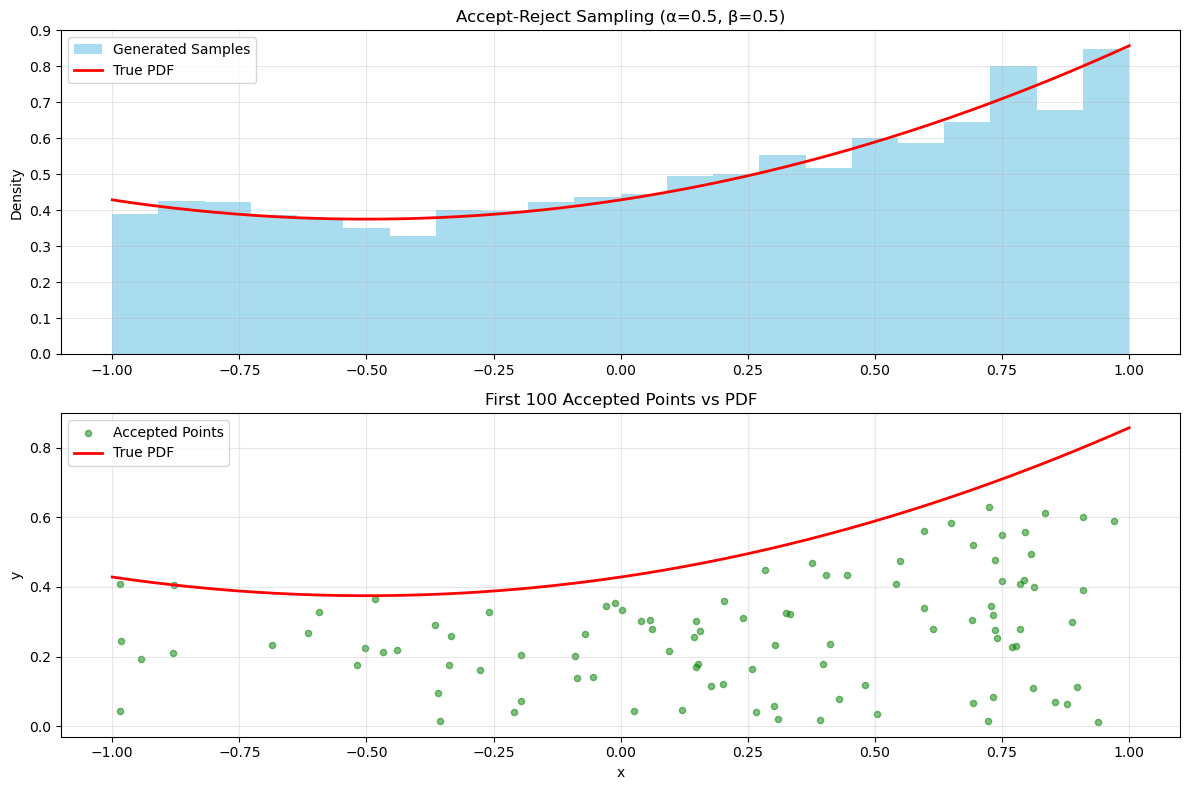

In [193]:
# Create visualization
plt.figure(figsize=(12, 8))

# Create two subplots
plt.subplot(2, 1, 1)

# Plot histogram of x values
plt.hist(samples, bins="auto", density=True, alpha=0.7, 
         label='Generated Samples', color='skyblue')

# Plot true PDF
x_plot = np.linspace(a, b, 200)
y_plot = pdf(x_plot, alpha, beta, a, b)
plt.plot(x_plot, y_plot, 'r-', label='True PDF', linewidth=2)

plt.title(f'Accept-Reject Sampling (α={alpha}, β={beta})')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Add second subplot to visualize the accept/reject process
plt.subplot(2, 1, 2)

# Plot a scatter of accepted points
plt.scatter(samples[:100], accepted_y[:100], alpha=0.5, 
           label='Accepted Points', color='green', s=20)

# Plot the PDF again
plt.plot(x_plot, y_plot, 'r-', label='True PDF', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('First 100 Accepted Points vs PDF')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [194]:
def calculate_moment_covariance(samples):
    """Calculate covariance matrix of the first and second moments using equation 3.67."""
    n = len(samples)
    mean = np.mean(samples)
    
    # Calculate covariances between different powers of X
    cov_matrix = np.zeros((2, 2))
    
    for i in range(n):
        # Vector of [X_i^1 - mean(X^1), X_i^2 - mean(X^2)]
        diff_vector = np.array([
            samples[i] - mean,
            samples[i]**2 - np.mean(samples**2)
        ])
        cov_matrix += np.outer(diff_vector, diff_vector)
    
    return cov_matrix / (n * (n - 1))


In [195]:
def calculate_parameter_jacobian(samples, a, b):
    """Calculate the Jacobian matrix ∂θᵢ/∂μⱼ for error propagation."""
    def d_k(k):
        return (b**k - a**k) / k
    
    # Get necessary d_k values
    d2, d3, d4, d5 = d_k(2), d_k(3), d_k(4), d_k(5)
    
    # Calculate N (normalization)
    E_X = np.mean(samples)
    E_X2 = np.mean(samples**2)
    
    # Initial N (assuming current α, β are good approximations)
    N = 1 / (d_k(1) + 0.5 * d2 + 0.5 * d3)  # Using α=β=0.5 as approximation
    
    # Derivatives ∂α/∂μ₁, ∂α/∂μ₂, ∂β/∂μ₁, ∂β/∂μ₂
    # where μ₁ = E(X) and μ₂ = E(X²)
    jacobian = np.zeros((2, 2))
    
    # ∂α/∂E(X)
    jacobian[0,0] = d5 / (N * d3 * d5 - N * d4**2)
    
    # ∂α/∂E(X²)
    jacobian[0,1] = -d4 / (N * d3 * d5 - N * d4**2)
    
    # ∂β/∂E(X)
    jacobian[1,0] = d4 / (N * d4**2 - N * d5 * d3)
    
    # ∂β/∂E(X²)
    jacobian[1,1] = -d3 / (N * d4**2 - N * d5 * d3)
    
    return jacobian

In [196]:
def mom_estimates(samples, a, b):
    """Compute Method of Moments estimates."""
    # Sample moments
    E_X = np.mean(samples)  # First moment
    E_X2 = np.mean(samples**2)  # Second moment
    
    # Theoretical moments
    def d_k(k):
        return (b**k - a**k) / k
    
    # Simplify by solving for alpha and beta
    d1, d2, d3 = d_k(1), d_k(2), d_k(3)
    d4, d5 = d_k(4), d_k(5)

    def calculate_N(alpha, beta):
        d1 = d_k(1)
        return 1 / (d1 + alpha * d2 + beta * d3)
    N = calculate_N(0.5, 0.5)

    # Calculate α using the given formula
    alpha = (d5*E_X - d4*E_X2 - N*d2*d5 + N*d3*d4) / (N*d3*d5 - N*d4**2)
    
    # Calculate β using the given formula
    beta = (d4*E_X - d3*E_X2 + N*d3*d3 - N*d4*d2) / (N*d4**2 - N*d5*d3)

    # Calculate moment covariance matrix using equation 3.67
    moment_cov = calculate_moment_covariance(samples)
    
    # Calculate Jacobian for error propagation
    jacobian = calculate_parameter_jacobian(samples, a, b)
    
    # Propagate uncertainties using equation 3.68
    param_cov = jacobian @ moment_cov @ jacobian.T
    return alpha, beta,param_cov
    

In [197]:
from scipy.optimize import minimize

In [198]:
def mle_estimates(samples, a,b):
    def negative_log_likelihood(params):
        alpha, beta = params
        log_likelihoods = np.log(pdf(samples, alpha, beta, a, b))
        return -np.sum(log_likelihoods)
    alpha_init, beta_init=0.4,0.4
    result = minimize(negative_log_likelihood, 
                     x0=[alpha_init, beta_init],
                     method='Nelder-Mead')
    alpha_mle, beta_mle = result.x
    # Compute covariance matrix using observed Fisher information
    epsilon = 1e-5
    hessian = np.zeros((2, 2))
    
    # Numerical approximation of Hessian
    for i in range(2):
        for j in range(2):
            params1 = result.x.copy()
            params2 = result.x.copy()
            params1[i] += epsilon
            params1[j] += epsilon
            params2[i] -= epsilon
            params2[j] -= epsilon
            
            hessian[i,j] = (negative_log_likelihood(params1) - 
                           2*negative_log_likelihood(result.x) + 
                           negative_log_likelihood(params2)) / (epsilon**2)
    
  
    mle_cov = np.linalg.inv(hessian)
    return alpha_mle, beta_mle,mle_cov
    


In [199]:
# Compute estimates
alpha_mom, beta_mom,cov_matrix= mom_estimates(samples, a, b)
alpha_err = np.sqrt(cov_matrix[0,0])
beta_err = np.sqrt(cov_matrix[1,1])
alpha_mle, beta_mle,mle_cov= mle_estimates(samples, a, b)

print("True values:")
print(f"α = {true_alpha:.3f}, β = {true_beta:.3f}\n")

print("Method of Moments estimates:")
print(f"α = {alpha_mom:.3f} ± {alpha_err:.3f}")
print(f"β = {beta_mom:.3f} ± {beta_err:.3f}")

print("Maximum Likelihood estimates:")
print(f"α̂ = {alpha_mle:.3f} ± {np.sqrt(mle_cov[0,0]):.3f}")
print(f"β̂ = {beta_mle:.3f} ± {np.sqrt(mle_cov[1,1]):.3f}")

True values:
α = 0.500, β = 0.500

Method of Moments estimates:
α = 0.491 ± 0.021
β = 0.481 ± 0.018
Maximum Likelihood estimates:
α̂ = 0.485 ± 0.011
β̂ = 0.451 ± 0.022


# Question 2

25 bins, 4 parameters (3 parameter for Gaussian, and 1 parameter for plain), 25-4-1 (the last constraint comes from the normalization factor)=20.

# Question 3

In [200]:
from scipy import stats

In [201]:
def calculate_poisson_chi2_test(events, intervals, expected_mean=None):
    """
    Calculate chi-square test for Poisson distribution.
    If expected_mean is None, estimate it from the data.
    """
    # Calculate total number of observations and events
    total_intervals = np.sum(intervals)
    total_events = np.sum(events * intervals)
    
    # Estimate mean if not provided
    if expected_mean is None:
        expected_mean = total_events / total_intervals
    
    # Calculate expected frequencies
    expected = total_intervals * stats.poisson.pmf(events, expected_mean)
    
    # Calculate chi-square only for bins with expected frequency ≥ 5
    valid_bins = expected >= 5
    chi2 = np.sum(((intervals[valid_bins] - expected[valid_bins])**2) / expected[valid_bins])
    
    # Degrees of freedom: number of valid bins - 1 (for mean estimation) - 1
    dof = np.sum(valid_bins) - 2
    
    # Calculate p-value
    p_value = 1 - stats.chi2.cdf(chi2, dof)
    
    return expected_mean, chi2, dof, p_value


In [202]:
# Data
events = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
intervals = np.array([1042, 860, 307, 78, 15, 3, 0, 0, 0, 1])

In [203]:
# Analysis with all data
print("Analysis including all data:")
mean_all, chi2_all, dof_all, p_all = calculate_poisson_chi2_test(events, intervals)
print(f"Estimated mean: {mean_all:.3f}")
print(f"Chi-square: {chi2_all:.3f}")
print(f"Degrees of freedom: {dof_all}")
print(f"p-value: {p_all:.3e}")

print("\nAnalysis excluding the last bin (9 events):")
mean_excl, chi2_excl, dof_excl, p_excl = calculate_poisson_chi2_test(events[:-1], intervals[:-1])
print(f"Estimated mean: {mean_excl:.3f}")
print(f"Chi-square: {chi2_excl:.3f}")
print(f"Degrees of freedom: {dof_excl}")
print(f"p-value: {p_excl:.3e}")

Analysis including all data:
Estimated mean: 0.777
Chi-square: 2.802
Degrees of freedom: 3
p-value: 4.232e-01

Analysis excluding the last bin (9 events):
Estimated mean: 0.774
Chi-square: 2.769
Degrees of freedom: 3
p-value: 4.287e-01


# Question 4

$$ \begin{align}
\int_{x_0} f(x|\theta_0) dx&= \alpha\\
\int_{x_0} f(x|\theta_1) dx&=\beta\\
\beta=\int_{x_0} \frac{f(x|\theta_1)}{f(x|\theta_0)} f(x|\theta_0)dx
&=E(\frac{f(x|\theta_1)}{f(x|\theta_0)})
\end{align}$$

So the power is maximised when the expected value is maximised, given the NP test statistic, that value is maximised.

# Question 5

In [204]:
x_plus = -9.3
y_plus = -1.3
x_minus = 5.7
y_minus = 6.5

sigma_x_plus = 8.2
sigma_y_plus = 8.4
sigma_x_minus = 8.2
sigma_y_minus = 8.3

In [205]:
corr_matrix = np.array([
    [1.0, -0.1, -0.05, 0.1],
    [-0.1, 1.0, 0.1, -0.05],
    [-0.05, 0.1, 1.0, 0.1],
    [0.1, -0.05, 0.1, 1.0]
])


In [206]:
sigmas = np.array([sigma_x_plus, sigma_y_plus, sigma_x_minus, sigma_y_minus])
cov_matrix = corr_matrix * np.outer(sigmas, sigmas)

In [207]:
data = np.array([x_plus, y_plus, x_minus, y_minus])

In [208]:
def model(params):
    """Calculate model predictions for given parameters."""
    r, gamma, delta = params
    x_plus_pred = r * np.cos(delta + gamma)
    y_plus_pred = r * np.sin(delta + gamma)
    x_minus_pred = r * np.cos(delta - gamma)
    y_minus_pred = r * np.sin(delta - gamma)
    return np.array([x_plus_pred, y_plus_pred, x_minus_pred, y_minus_pred])

In [ ]:
def neg_log_likelihood(params):
    """Calculate negative log-likelihood."""
    pred = model(params)
    diff = data - pred #This feels like unnormalized chi-squared
    return 0.5 * diff.T @ np.linalg.inv(cov_matrix) @ diff

In [210]:
result = minimize(neg_log_likelihood, [10.0, 0.1, 0.1], method='Nelder-Mead')
r_ml, gamma_ml, delta_ml = result.x

In [212]:
from numdifftools import Hessian

In [213]:
# Calculate Hessian matrix at ML point
hessian_func = Hessian(neg_log_likelihood)
hessian_matrix = hessian_func(result.x)

In [214]:
param_cov = np.linalg.inv(hessian_matrix)

In [215]:
# Extract uncertainties (sqrt of diagonal elements)
uncertainties = np.sqrt(np.diag(param_cov))
    
# Calculate correlation matrix
param_sigmas = np.sqrt(np.diag(param_cov))
param_corr = param_cov / np.outer(param_sigmas, param_sigmas)

In [216]:
print("\nMaximum Likelihood Estimates with Uncertainties:")
print(f"r = {r_ml:.2f} ± {uncertainties[0]:.2f}")
print(f"γ = {gamma_ml:.2f} ± {uncertainties[1]:.2f} rad = ({np.degrees(gamma_ml):.1f} ± {np.degrees(uncertainties[1]):.1f})°")
print(f"δ = {delta_ml:.2f} ± {uncertainties[2]:.2f} rad = ({np.degrees(delta_ml):.1f} ± {np.degrees(uncertainties[2]):.1f})°")
    
print("\nParameter Correlation Matrix:")
param_names = ['r', 'γ', 'δ']
print("     " + "  ".join(f"{name:>8}" for name in param_names))
for i, name in enumerate(param_names):
    print(f"{name:4}", end=" ")
    print("  ".join(f"{param_corr[i,j]:8.3f}" for j in range(3)))


Maximum Likelihood Estimates with Uncertainties:
r = -9.04 ± 5.77
γ = 1.21 ± 0.60 rad = (69.6 ± 34.2)°
δ = -1.07 ± 0.67 rad = (-61.5 ± 38.7)°

Parameter Correlation Matrix:
            r         γ         δ
r       1.000     0.009     0.101
γ       0.009     1.000     0.048
δ       0.101     0.048     1.000


In [221]:
# Profile likelihood scan for r
r_vals = np.linspace(-30, 30, 1000)

def profile_likelihood_r(r_val):
    """Compute profile likelihood for fixed r."""
    def constrained_nll(params):
        gamma, delta = params
        return neg_log_likelihood([r_val, gamma, delta])
    
    result = minimize(constrained_nll, [gamma_ml, delta_ml], method='Nelder-Mead')
    return result.fun

In [222]:
profile_likes = [profile_likelihood_r(r) for r in r_vals]
profile_likes = np.array(profile_likes)
delta_nll = 2 * (profile_likes - np.min(profile_likes))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


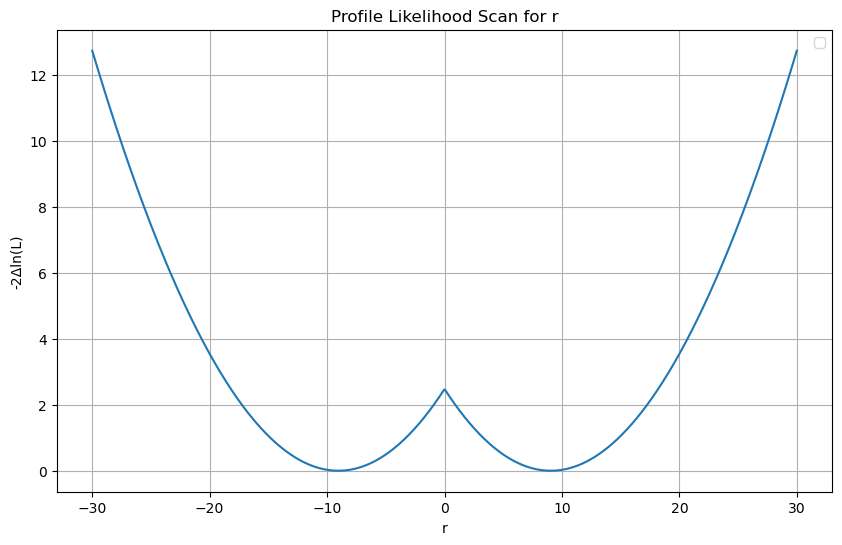

In [224]:
# Plot profile likelihood
plt.figure(figsize=(10, 6))
plt.plot(r_vals, delta_nll)
plt.xlabel('r')
plt.ylabel('-2Δln(L)')
plt.title('Profile Likelihood Scan for r')
plt.grid(True)
plt.legend()
plt.show()

Because sin and cos are priodic, and there's sign ambiguity in the above solution. Then, if we simply use the symmetric intervals to deduce the confidence interval, then it will be problematic as we have two minimums here.

We have two equivalent minima (r ≈ ±10), making a single uncertainty estimate ambiguous. For each minimum, the likelihood is asymmetric. Even focusing on just the positive minimum, we can't get a simple confidence interval because the likelihood has multiple crossings of any given threshold

c & d?
